In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BASE_DIR = '/content/drive/MyDrive/COMP90073/Assignment2/A2-data'

### Import Libraries

In [4]:
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from torch.amp import GradScaler, autocast
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from torch.utils.data import TensorDataset, DataLoader
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import numpy as np
import torch

import io
import torch
from torchvision import transforms
from PIL import Image

from PIL import Image
import io
import torch
from torchvision import transforms

import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np


torch.manual_seed(0)
np.random.seed(0)

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
logger.addHandler(handler)

### Model architecture as in model.py

In [5]:
# Define the GhostBatchNorm, conv_bn_relu, conv_pool_norm_act, Model, and Averager classes as per model.py

class GhostBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        running_mean = torch.zeros(num_features * num_splits)
        running_var = torch.ones(num_features * num_splits)
        self.weight.requires_grad = False
        self.num_splits = num_splits
        self.register_buffer("running_mean", running_mean)
        self.register_buffer("running_var", running_var)

    def train(self, mode=True):
        if (self.training is True) and (mode is False):
            self.running_mean = torch.mean(
                self.running_mean.view(self.num_splits, self.num_features), dim=0
            ).repeat(self.num_splits)
            self.running_var = torch.mean(
                self.running_var.view(self.num_splits, self.num_features), dim=0
            ).repeat(self.num_splits)
        return super().train(mode)

    def forward(self, input):
        n, c, h, w = input.shape
        if self.training or not self.track_running_stats:
            assert n % self.num_splits == 0, f"Batch size ({n}) must be divisible by num_splits ({self.num_splits}) of GhostBatchNorm"
            return F.batch_norm(
                input.view(-1, c * self.num_splits, h, w),
                self.running_mean,
                self.running_var,
                self.weight.repeat(self.num_splits),
                self.bias.repeat(self.num_splits),
                True,
                self.momentum,
                self.eps,
            ).view(n, c, h, w)
        else:
            return F.batch_norm(
                input,
                self.running_mean[: self.num_features],
                self.running_var[: self.num_features],
                self.weight,
                self.bias,
                False,
                self.momentum,
                self.eps,
            )

def conv_bn_relu(c_in, c_out, kernel_size=(3, 3), padding=(1, 1)):
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, kernel_size=kernel_size, padding=padding, bias=False),
        GhostBatchNorm(c_out, num_splits=16),
        nn.CELU(alpha=0.3),
    )

def conv_pool_norm_act(c_in, c_out):
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, kernel_size=(3, 3), padding=(1, 1), bias=False),
        nn.MaxPool2d(kernel_size=2, stride=2),
        GhostBatchNorm(c_out, num_splits=16),
        nn.CELU(alpha=0.3),
    )

class Model(nn.Module):
    def __init__(self, first_layer_weights, c_in, c_out, scale_out):
        super().__init__()

        c = first_layer_weights.size(0)

        conv1 = nn.Conv2d(c_in, c, kernel_size=(3, 3), padding=(1, 1), bias=False)
        conv1.weight.data = first_layer_weights
        conv1.weight.requires_grad = False

        self.conv1 = conv1
        self.conv2 = conv_bn_relu(c, 64, kernel_size=(1, 1), padding=0)
        self.conv3 = conv_pool_norm_act(64, 128)
        self.conv4 = conv_bn_relu(128, 128)
        self.conv5 = conv_bn_relu(128, 128)
        self.conv6 = conv_pool_norm_act(128, 256)
        self.conv7 = conv_pool_norm_act(256, 512)
        self.conv8 = conv_bn_relu(512, 512)
        self.conv9 = conv_bn_relu(512, 512)
        self.pool10 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.linear11 = nn.Linear(512, c_out, bias=False)
        self.scale_out = scale_out

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x + self.conv5(self.conv4(x))
        x = self.conv6(x)
        x = self.conv7(x)
        x = x + self.conv9(self.conv8(x))
        x = self.pool10(x)
        x = x.reshape(x.size(0), x.size(1))
        x = self.linear11(x)
        x = self.scale_out * x
        return x

class Averager(nn.Module):
    def __init__(self, c_in, c_out, scale_out):
        super().__init__()

        self.model = Model(torch.zeros([9, c_in, 3, 3]), c_in, c_out, scale_out)

        self.average_logits = True

    def forward(self, x):
        if self.average_logits:
            flipped_inputs = torch.flip(x, [-1])
            logits1 = self.model(x)
            logits2 = self.model(flipped_inputs)

            logits = torch.mean(torch.stack([logits1, logits2], dim=0), dim=0)
        else:
            logits = self.model(x)
        return logits

### Load model

In [6]:
# -------------------------------
# 2. Load the Pre-trained Model
# -------------------------------

def load_model(checkpoint_path='model_chkpt.pt', device='cuda'):
    """
    Loads the pre-trained Averager model from the checkpoint.

    Args:
        checkpoint_path (str): Path to the model checkpoint.
        device (torch.device): Device to load the model on.

    Returns:
        model (nn.Module): The loaded Averager model.
    """
    # Initialize the model architecture
    model_instance = Averager(c_in=1, c_out=10, scale_out=0.125)

    # Load the state dictionary
    state_dict = torch.load(checkpoint_path, map_location=device)
    model_instance.model.load_state_dict(state_dict)


    model_instance.to(device)
    model_instance.eval()

    return model_instance


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Load the pre-trained model
model = load_model(checkpoint_path=os.path.join(BASE_DIR, 'model_chkpt.pt'), device=device)
logger.info("Pre-trained model loaded successfully.")

Using device: cuda
INFO:__main__:Using device: cuda
<ipython-input-6-e15024d2c0a2>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path,

In [7]:
# -------------------------------
# 3. Load and Inspect the Dataset
# -------------------------------

def load_red_team_test_set(dataset_path='dataset.pt'):
    """
    Loads the Red Team test dataset.

    Args:
        dataset_path (str): Path to the test dataset.

    Returns:
        dataset (TensorDataset): The loaded test dataset.
    """
    try:
        dataset = torch.load(dataset_path)
    except Exception as e:
        logger.error(f"Failed to load dataset: {e}")
        raise e

    if isinstance(dataset, TensorDataset):
        images, labels = dataset.tensors
        logger.info(f"\nImages shape: {images.shape}")
        logger.info(f"\nLabels shape: {labels.shape}")
        logger.info(f"\nMinimum pixel value in the dataset: {images.min().item()}")
        logger.info(f"\nMaximum pixel value in the dataset: {images.max().item()}")
        return dataset
    else:
        logger.error("Loaded data is not a TensorDataset. Please check the structure.")
        return None

# Load the test dataset
test_dataset = load_red_team_test_set(dataset_path=os.path.join(BASE_DIR, 'dataset.pt'))
if test_dataset is None:
    raise ValueError("Failed to load test dataset.")

test_images, test_labels = test_dataset.tensors
logger.info(f"\nTest images shape: {test_images.shape}")
logger.info(f"\nTest labels shape: {test_labels.shape}")

<ipython-input-7-690d1a152346>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_path)

Images shape: torch.Size([10000, 1, 32, 32])
INFO:__main

In [8]:
# Check for empty image tensors in the entire dataset
empty_samples = []
for i in range(len(test_dataset)):
    img, lbl = test_dataset[i]
    if img.numel() == 0:
        empty_samples.append(i)

if empty_samples:
    print(f"Empty image tensors found at indices: {empty_samples}")
else:
    print("No empty image tensors found in the dataset.")

No empty image tensors found in the dataset.


In [9]:
# -------------------------------
# 4. Calculate Mean and Std
# -------------------------------

def calculate_mean_std(loader):
    """
    Calculates the mean and standard deviation of the dataset.

    Args:
        loader (DataLoader): DataLoader for the dataset.

    Returns:
        mean (torch.Tensor): Mean of the dataset.
        std (torch.Tensor): Standard deviation of the dataset.
    """
    mean = 0.0
    std = 0.0
    total_samples = 0
    for images_batch, _ in loader:
        batch_samples = images_batch.size(0)
        images_batch = images_batch.view(batch_samples, images_batch.size(1), -1)
        mean += images_batch.mean(2).sum(0)
        std += images_batch.std(2).sum(0)
        total_samples += batch_samples
    mean /= total_samples
    std /= total_samples
    return mean, std

# Create DataLoader for mean and std calculation
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Calculate mean and std
mean, std = calculate_mean_std(test_loader)
mean = mean.to(device)
std = std.to(device)
logger.info(f"Calculated Mean: {mean}")
logger.info(f"Calculated Std: {std}")

Calculated Mean: tensor([0.0127], device='cuda:0')
INFO:__main__:Calculated Mean: tensor([0.0127], device='cuda:0')
Calculated Std: tensor([0.8197], device='cuda:0')
INFO:__main__:Calculated Std: tensor([0.8197], device='cuda:0')


In [10]:

# -------------------------------
# 5. Verify and Prepare the Dataset
# -------------------------------

transformed_dataset = test_dataset

# Verify that all images are valid
empty_samples = []
for i in range(len(transformed_dataset)):
    img, lbl = transformed_dataset[i]
    if img.numel() == 0:
        empty_samples.append(i)

if empty_samples:
    logger.warning(f"Empty image tensors found at indices: {empty_samples}")
else:
    logger.info("No empty image tensors found in the dataset.")

# -------------------------------
# 6. Define the Custom Collate Function
# -------------------------------

def custom_collate_fn(batch):
    """
    Custom collate function to stack images and labels.

    Args:
        batch (list): List of tuples (image, label).

    Returns:
        images (torch.Tensor): Stacked images tensor.
        labels (torch.Tensor): Tensor of labels.
    """
    # Filter out samples with empty images
    batch = [item for item in batch if item[0].numel() > 0]

    if not batch:
        return torch.empty(0), torch.empty(0, dtype=torch.long)

    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    return torch.stack(images), torch.tensor(labels)

No empty image tensors found in the dataset.
INFO:__main__:No empty image tensors found in the dataset.


In [11]:
# -------------------------------
# 7. Define Helper Functions
# -------------------------------

# Constants for Rescaling
UNNORMALIZED_MIN = -1.6267
UNNORMALIZED_MAX = 1.6521
RESCALE_SHIFT = -UNNORMALIZED_MIN
RESCALE_SCALE = UNNORMALIZED_MAX - UNNORMALIZED_MIN

def unnormalize(tensor, mean=0.0127, std=0.8197):
    """
    Unnormalize a tensor image.

    Args:
        tensor (torch.Tensor): Normalized image tensor.
        mean (float): Mean used for normalization.
        std (float): Std used for normalization.

    Returns:
        torch.Tensor: Unnormalized image tensor.
    """
    return tensor * std + mean

def rescale_to_unit_range(tensor, min_val=-1.6, max_val=1.6):
    """
    Rescale tensor values from [min_val, max_val] to [0, 1].

    Args:
        tensor (torch.Tensor): Input tensor.
        min_val (float): Minimum value of the tensor.
        max_val (float): Maximum value of the tensor.

    Returns:
        torch.Tensor: Rescaled tensor within [0, 1].
    """
    tensor_rescaled = (tensor - min_val) / (max_val - min_val)
    tensor_rescaled = torch.clamp(tensor_rescaled, 0.0, 1.0)
    return tensor_rescaled

def calculate_metrics(original, adversarial, mean=0.0127, std=0.8197):
    """
    Calculate SSIM, PSNR, L2 Norm, and L-Infinity Norm between original and adversarial images.

    Args:
        original (torch.Tensor): Original image tensor of shape [1, H, W].
        adversarial (torch.Tensor): Adversarial image tensor of shape [1, H, W].
        mean (float): Mean used for unnormalization.
        std (float): Std used for unnormalization.

    Returns:
        tuple: (ssim_score, psnr_score, l2_norm, linf_norm)
    """
    # Unnormalize
    original_unnorm = unnormalize(original, mean, std)
    adversarial_unnorm = unnormalize(adversarial, mean, std)

    # Rescale to [0, 1]
    original_rescaled = rescale_to_unit_range(original_unnorm)
    adversarial_rescaled = rescale_to_unit_range(adversarial_unnorm)

    # Move tensors to CPU and convert to NumPy
    original_np = original_rescaled.squeeze().cpu().numpy()
    adversarial_np = adversarial_rescaled.squeeze().cpu().numpy()


    ssim_score = ssim(original_np, adversarial_np, data_range=1.0, multichannel=False)
    psnr_score = psnr(original_np, adversarial_np, data_range=1.0)
    l2_norm = torch.norm(adversarial - original, p=2).item()
    linf_norm = torch.norm(adversarial - original, p=float('inf')).item()

    return ssim_score, psnr_score, l2_norm, linf_norm

def visualize_adversarial(original, adversarial, mean, std, index=0):
    """
    Visualizes the original, adversarial, and perturbation images.

    Args:
        original (torch.Tensor): Original image tensor.
        adversarial (torch.Tensor): Adversarial image tensor.
        mean (torch.Tensor): Mean used for normalization.
        std (torch.Tensor): Std used for normalization.
        index (int): Index of the sample to visualize.
    """
    # Unnormalize the images
    original_unnorm = unnormalize(original[index], mean, std).cpu().numpy()
    adversarial_unnorm = unnormalize(adversarial[index], mean, std).cpu().numpy()

    # Rescale to [0, 1]
    original_rescaled = rescale_to_unit_range(original_unnorm)
    adversarial_rescaled = rescale_to_unit_range(adversarial_unnorm)

    # Clip pixel values to [0, 1]
    original_rescaled = np.clip(original_rescaled, 0, 1)
    adversarial_rescaled = np.clip(adversarial_rescaled, 0, 1)

    # Calculate the perturbation
    perturbation = adversarial_rescaled - original_rescaled

    # Calculate PSNR
    mse = np.mean((original_rescaled - adversarial_rescaled) ** 2)
    if mse == 0:
        psnr_score = 'Infinity'
    else:
        psnr_score = 10 * np.log10(1.0 / mse)

    # Prepare images for visualization
    original_img = original_rescaled
    adversarial_img = adversarial_rescaled
    perturbation_img = perturbation

    # Plot the images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_img, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(adversarial_img, cmap='gray')
    axs[1].set_title('Adversarial Image')
    axs[1].axis('off')

    # Normalize perturbation for better visualization
    perturbation_normalized = (perturbation_img - perturbation_img.min()) / (perturbation_img.max() - perturbation_img.min()) if perturbation_img.max() != perturbation_img.min() else perturbation_img
    axs[2].imshow(perturbation_normalized, cmap='seismic')
    axs[2].set_title('Perturbation')
    axs[2].axis('off')

    plt.suptitle(f"PSNR: {psnr_score:.2f} dB")
    plt.tight_layout()
    plt.show()

### Investigate Preprocessing

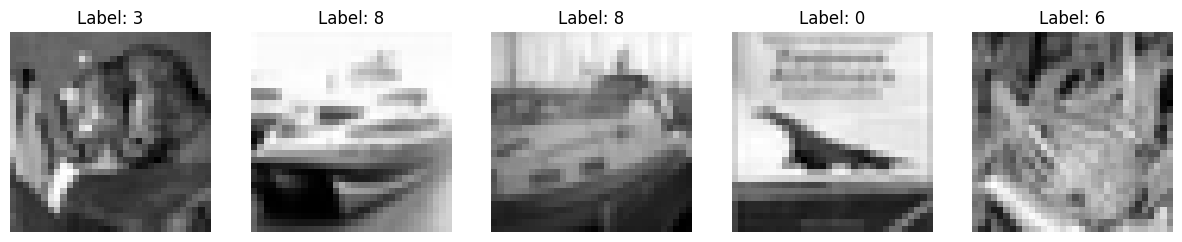

In [ ]:
# Display sample images
sample_indices = [0, 1, 2, 3, 4]
fig, axs = plt.subplots(1, len(sample_indices), figsize=(15, 3))
for i, idx in enumerate(sample_indices):
    axs[i].imshow(test_images[idx].squeeze(), cmap='gray')
    axs[i].set_title(f"Label: {test_labels[idx].item()}")
    axs[i].axis('off')
plt.show()

In [ ]:
# Calculate statistics from dataset.pt
pixel_values = test_images.view(len(test_images), -1).numpy()
means = pixel_values.mean(axis=1)
stds = pixel_values.std(axis=1)
print(f"Mean pixel value: {means.mean():.4f}, Std: {stds.mean():.4f}")
print(f"Max pixel value: {pixel_values.max():.4f}, Min: {pixel_values.min():.4f}")

Mean pixel value: 0.0127, Std: 0.8193
Max pixel value: 2.1705, Min: -2.0104


### Baseline metrics

In [ ]:
# Evaluate model accuracy on clean test data
def evaluate_clean_accuracy(model, test_images, test_labels, device='cuda'):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(zip(test_images, test_labels), total=len(test_images), desc="Evaluating Clean Accuracy"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images.unsqueeze(0))
            _, predicted = torch.max(outputs.data, 1)
            total += 1
            correct += (predicted == labels).item()
    accuracy = 100 * correct / total
    return accuracy

clean_accuracy = evaluate_clean_accuracy(model, test_images, test_labels, device=device)
print(f"\nBaseline Model Accuracy on Clean Data: {clean_accuracy:.2f}%")

Evaluating Clean Accuracy: 100%|██████████| 10000/10000 [00:30<00:00, 329.24it/s]


Baseline Model Accuracy on Clean Data: 93.32%


Generating Predictions: 100%|██████████| 10000/10000 [00:29<00:00, 333.58it/s]


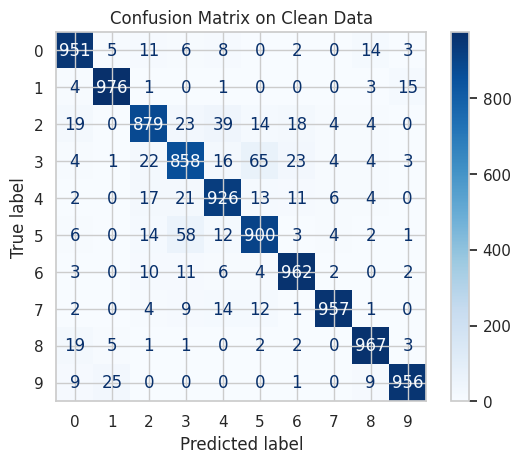

In [ ]:
def plot_confusion_matrix(model, test_images, test_labels, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(zip(test_images, test_labels), total=len(test_images), desc="Generating Predictions"):
            images = images.to(device)
            outputs = model(images.unsqueeze(0))
            _, predicted = torch.max(outputs.data, 1)
            all_preds.append(predicted.item())
            all_labels.append(labels.item())
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix on Clean Data")
    plt.show()

plot_confusion_matrix(model, test_images, test_labels, device=device)

In [ ]:
def per_class_accuracy(model, test_images, test_labels, num_classes=10, device='cuda'):
    model.eval()
    correct = [0 for _ in range(num_classes)]
    total = [0 for _ in range(num_classes)]
    with torch.no_grad():
        for images, labels in tqdm(zip(test_images, test_labels), total=len(test_images), desc="Calculating Per-Class Accuracy"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images.unsqueeze(0))
            _, predicted = torch.max(outputs.data, 1)
            c = labels.item()
            correct[c] += (predicted == labels).sum().item()
            total[c] += 1
    for i in range(num_classes):
        if total[i] > 0:
            print(f"Class {i}: {100 * correct[i] / total[i]:.2f}%")
        else:
            print(f"Class {i}: No samples")

per_class_accuracy(model, test_images, test_labels, num_classes=10, device=device)

Calculating Per-Class Accuracy: 100%|██████████| 10000/10000 [00:37<00:00, 263.81it/s]

Class 0: 95.10%
Class 1: 97.60%
Class 2: 87.90%
Class 3: 85.80%
Class 4: 92.60%
Class 5: 90.00%
Class 6: 96.20%
Class 7: 95.70%
Class 8: 96.70%
Class 9: 95.60%


In [ ]:
def classification_metrics(model, test_images, test_labels, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(zip(test_images, test_labels), total=len(test_images), desc="Generating Predictions for Metrics"):
            images = images.to(device)
            outputs = model(images.unsqueeze(0))
            _, predicted = torch.max(outputs.data, 1)
            all_preds.append(predicted.item())
            all_labels.append(labels)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"\nPrecision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

classification_metrics(model, test_images, test_labels, device=device)

Generating Predictions for Metrics: 100%|██████████| 10000/10000 [00:37<00:00, 266.55it/s]



Precision: 0.93
Recall: 0.93
F1-Score: 0.93


### Execute attack (with PGD)

In [40]:
def iterative_gradient_attack(model, image, label, target=None, epsilon=0.1, step_size=1e-3, max_iters=100, device='cuda', momentum_alpha=0.9):
    """
    Performs an iterative gradient-based attack on a single image with AMP optimization, L2 bound,
    random initialization, and momentum to stabilize the update direction.

    Args:
        model (nn.Module): The pre-trained PyTorch model.
        image (torch.Tensor): The input image tensor of shape (C, H, W).
        label (torch.Tensor): The true label tensor.
        target (torch.Tensor, optional): The target label tensor for targeted attacks. If None, performs untargeted attack.
        epsilon (float): The maximum L2 norm of the perturbation.
        step_size (float): The step size for each iteration.
        max_iters (int): The maximum number of iterations.
        device (str): Device to perform computations on ('cuda' recommended).
        momentum_alpha (float): Momentum factor to accumulate gradients.

    Returns:
        adversarial_image (torch.Tensor): The perturbed image tensor.
        success (bool): Indicates if the attack was successful.
        num_iters (int): Number of iterations performed.
    """
    # Define normalized min and max
    NORMALIZED_MIN = -2.0104
    NORMALIZED_MAX = 2.1705

    # Ensure the model is in evaluation mode
    model.eval()
    original_image = image.clone().detach().to(device)
    # Initialize adversarial image with small random perturbation within the epsilon L2 ball
    delta = torch.randn_like(image, device=device)
    delta = delta / torch.norm(delta.view(-1), p=2) * epsilon * 0.1
    adversarial_image = torch.clamp(original_image + delta, NORMALIZED_MIN, NORMALIZED_MAX).detach()
    adversarial_image.requires_grad = True

    # Define loss function
    loss_fn = nn.CrossEntropyLoss()

    # Initialize momentum
    momentum = torch.zeros_like(adversarial_image, device=device)

    for i in range(max_iters):
        with autocast('cuda'):
            # Forward pass
            outputs = model(adversarial_image.unsqueeze(0))
            if target is not None:
                # Targeted: minimize loss for target
                loss = loss_fn(outputs, target.unsqueeze(0))
            else:
                # Untargeted: maximize loss
                loss = -loss_fn(outputs, label.unsqueeze(0))

        # Backward pass
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            # Compute gradient sign with momentum
            grad = adversarial_image.grad
            grad_norm = torch.norm(grad.view(-1), p=2)
            if grad_norm == 0:
                normalized_grad = torch.zeros_like(grad)
            else:
                normalized_grad = grad / grad_norm

            # Update momentum
            momentum = momentum_alpha * momentum + normalized_grad

            # Update adversarial image with momentum
            if target is not None:
                # Targeted
                adversarial_image -= step_size * momentum
            else:
                # Untargeted
                adversarial_image += step_size * momentum

            # Project the perturbation onto the L2 ball
            perturbation = adversarial_image - original_image
            perturbation_norm = torch.norm(perturbation.view(-1), p=2)
            if perturbation_norm > epsilon:
                perturbation = perturbation * (epsilon / perturbation_norm)
                adversarial_image = torch.clamp(original_image + perturbation, NORMALIZED_MIN, NORMALIZED_MAX)
            else:
                adversarial_image = torch.clamp(original_image + perturbation, NORMALIZED_MIN, NORMALIZED_MAX)
            adversarial_image.requires_grad = True

        # Zero out the gradients for the next iteration
        if adversarial_image.grad is not None:
            adversarial_image.grad.zero_()

        # Check for attack success
        with torch.no_grad():
            new_outputs = model(adversarial_image.unsqueeze(0))
            _, predicted = new_outputs.max(1)
            if target is None and predicted.item() != label.item():
                return adversarial_image.detach(), True, i + 1
            elif target is not None and predicted.item() == target.item():
                return adversarial_image.detach(), True, i + 1

    return adversarial_image.detach(), False, max_iters

Performing Attacks: 100%|██████████| 1000/1000 [2:45:17<00:00,  9.92s/it]


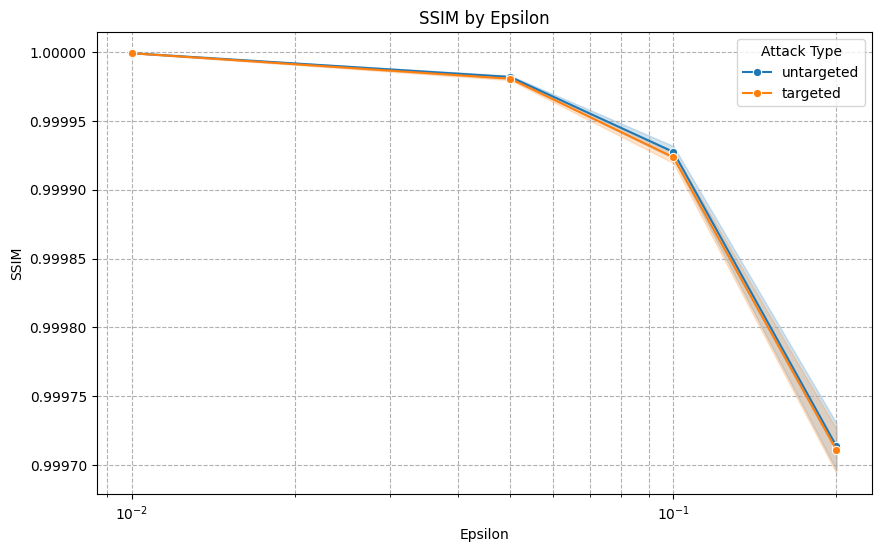

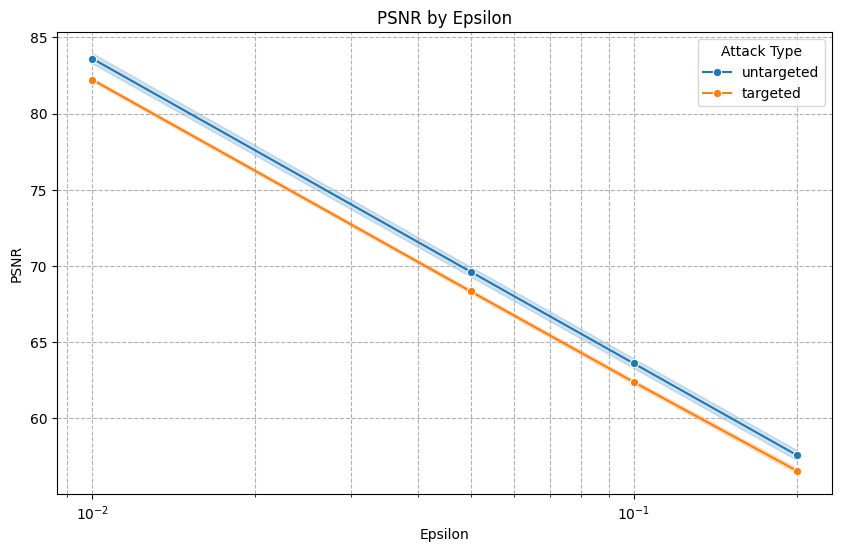

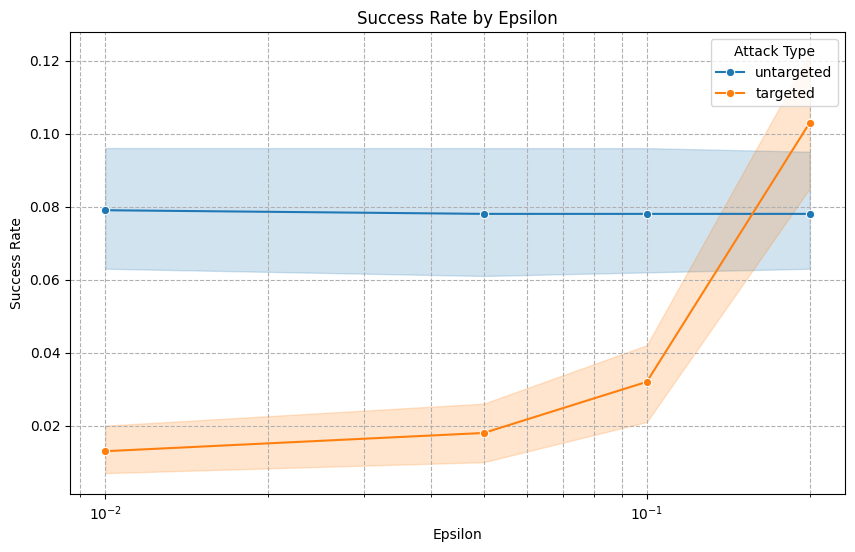

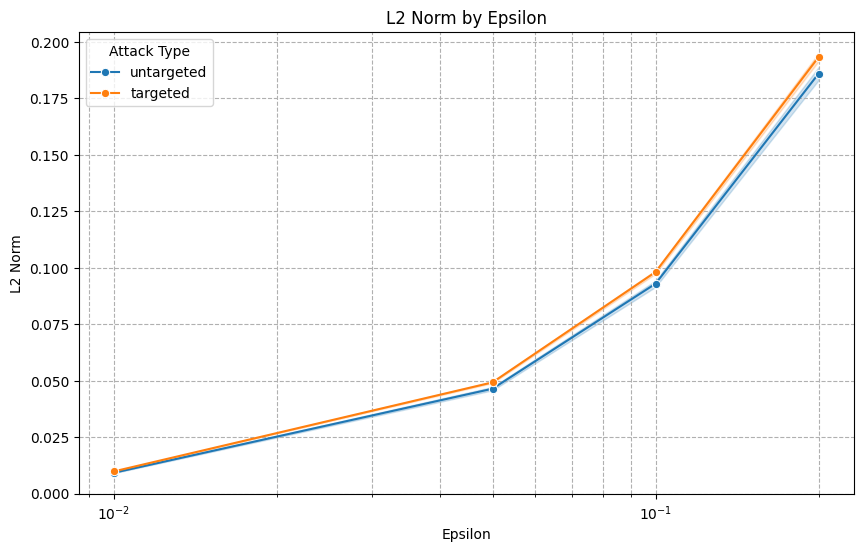

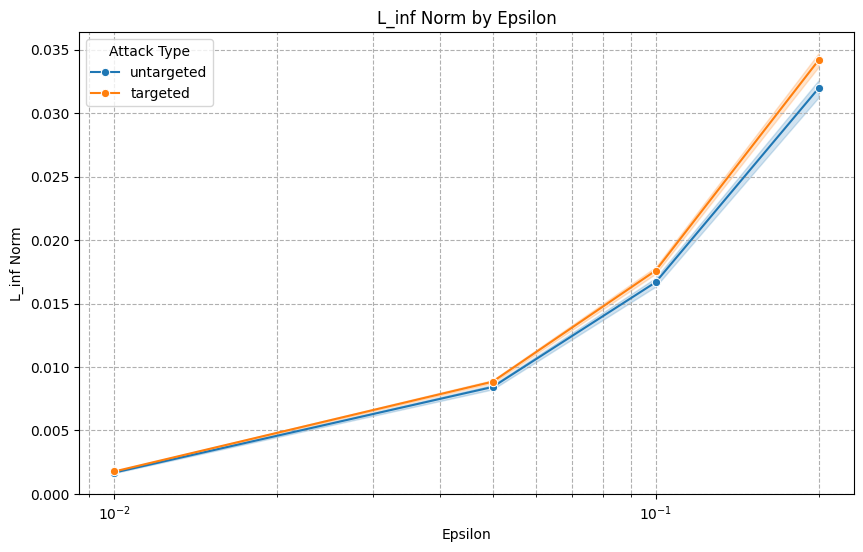

In [18]:
# Configuration for Attack Execution
EPSILONS = [0.01, 0.05, 0.1, 0.2]
MAX_ITERATIONS = 100
NUM_CLASSES = 10
TARGET_CLASS = 0

# Directories to save adversarial examples
ADV_DIR_UNTARGETED = 'adversarial_examples/untargeted_test_pgd/'
ADV_DIR_TARGETED = 'adversarial_examples/targeted_test_pgd/'
os.makedirs(ADV_DIR_UNTARGETED, exist_ok=True)
os.makedirs(ADV_DIR_TARGETED, exist_ok=True)

# Initialize results list
attack_results = []

# Attack Execution Loop
# Testing every 10th samples
for idx in tqdm(range(0, len(test_images), 10), desc="Performing Attacks"):
    image = test_images[idx].to(device)
    label = test_labels[idx].to(device)

    # Use the specified target class, but ensure it's different from the true label
    target_tensor = torch.tensor(TARGET_CLASS).to(device)
    if target_tensor == label:
        target_tensor = (target_tensor + 1) % NUM_CLASSES

    for epsilon in EPSILONS:
        step_size = epsilon / MAX_ITERATIONS
        # Untargeted Attack
        adv_image_ut, success_ut, iters_ut = iterative_gradient_attack(
            model=model,
            image=image,
            label=label,
            target=None,
            step_size=step_size,
            epsilon=epsilon,
            max_iters=MAX_ITERATIONS,
            device=device
        )

        ssim_score_ut, psnr_score_ut, l2_norm_ut, linf_norm_ut  = calculate_metrics(image, adv_image_ut, mean, std)

        if success_ut:
            adv_path_ut = os.path.join(ADV_DIR_UNTARGETED, f'adv_{idx}_eps_{epsilon}.pt')
            torch.save(adv_image_ut.cpu(), adv_path_ut)

        attack_results.append({
            'index': idx,
            'attack_type': 'untargeted',
            'epsilon': epsilon,
            'success': success_ut,
            'iterations': iters_ut,
            'l2_distance': l2_norm_ut,
            'ssim': ssim_score_ut,
            'psnr': psnr_score_ut,
            'linf_distance': linf_norm_ut
        })

        # Targeted Attack
        adv_image_tgt, success_tgt, iters_tgt = iterative_gradient_attack(
            model=model,
            image=image,
            label=label,
            target=target_tensor,
            step_size=step_size,
            epsilon=epsilon,
            max_iters=MAX_ITERATIONS,
            device=device
        )

        ssim_score_tgt, psnr_score_tgt, l2_norm_tgt, linf_norm_tgt  = calculate_metrics(image, adv_image_tgt, mean, std)

        if success_tgt:
            adv_path_tgt = os.path.join(ADV_DIR_TARGETED, f'adv_{idx}_eps_{epsilon}.pt')
            torch.save(adv_image_tgt.cpu(), adv_path_tgt)

        attack_results.append({
            'index': idx,
            'attack_type': 'targeted',
            'epsilon': epsilon,
            'success': success_tgt,
            'iterations': iters_tgt,
            'l2_distance': l2_norm_tgt,
            'ssim': ssim_score_tgt,
            'psnr': psnr_score_tgt,
            'linf_distance': linf_norm_tgt
        })

# Convert results to DataFrame
df_attack_results_pgd = pd.DataFrame(attack_results)
df_attack_results_pgd.head()
df_attack_results_pgd.to_csv(BASE_DIR+'/attack_results_pgd.csv', index=False)

# Plot SSIM vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd, x='epsilon', y='ssim', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('SSIM')
plt.title('SSIM by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot PSNR vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd, x='epsilon', y='psnr', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('PSNR')
plt.title('PSNR by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot Success Rate vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd, x='epsilon', y='success', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Success Rate')
plt.title('Success Rate by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot L2 Norm vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd, x='epsilon', y='l2_distance', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('L2 Norm')
plt.title('L2 Norm by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot L_inf Norm vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd, x='epsilon', y='linf_distance', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('L_inf Norm')
plt.title('L_inf Norm by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()


In [13]:
# load saved csv for use
df_attack_results_pgd = pd.read_csv(BASE_DIR+'/attack_results_pgd.csv')

df_attack_results_pgd.head()


,index,attack_type,epsilon,success,iterations,l2_distance,ssim,psnr,linf_distance
0,0,untargeted,0.01,False,100,0.01,1.000000,81.937156,0.001824
1,0,targeted,0.01,False,100,0.01,0.999999,81.936128,0.001630
2,0,untargeted,0.05,False,100,0.05,0.999987,67.957755,0.008636
3,0,targeted,0.05,False,100,0.05,0.999987,67.956384,0.009164
4,0,untargeted,0.10,False,100,0.10,0.999949,61.937198,0.016562


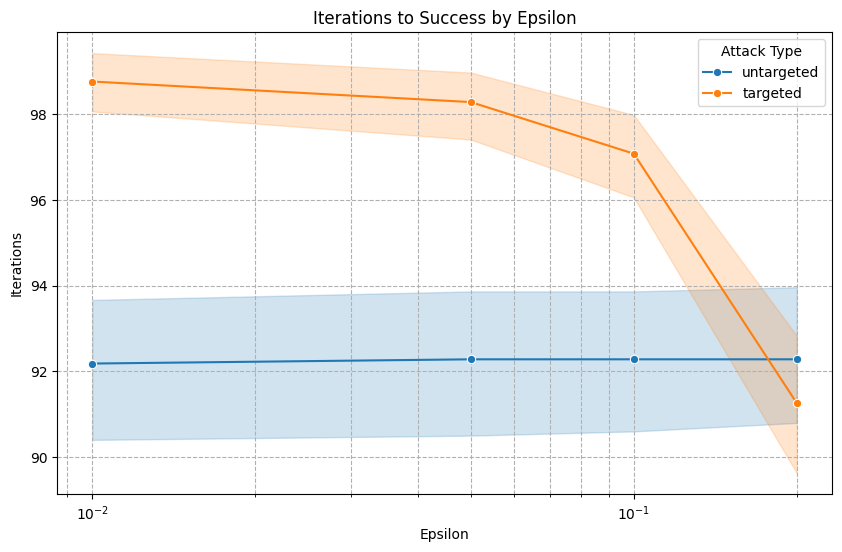

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd, x='epsilon', y='iterations', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Iterations')
plt.title('Iterations to Success by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()


Performing Attacks: 100%|██████████| 1000/1000 [1:09:24<00:00,  4.16s/it]


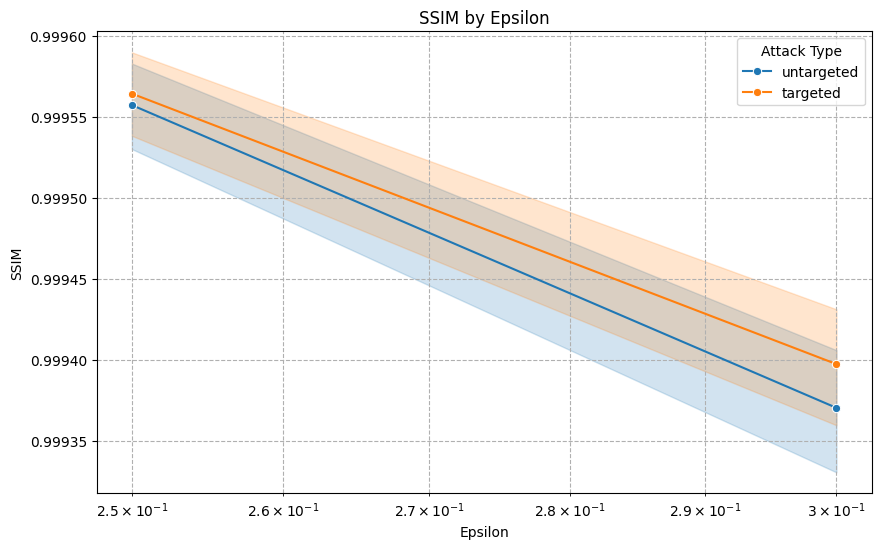

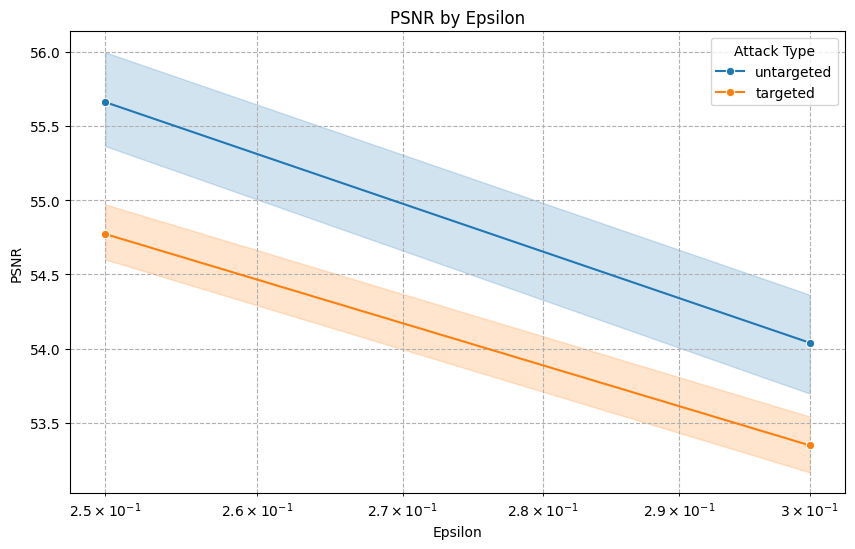

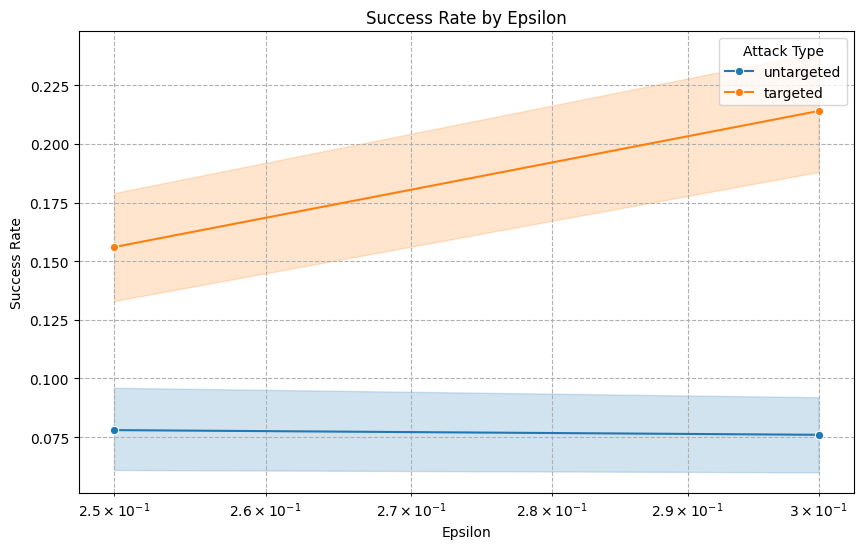

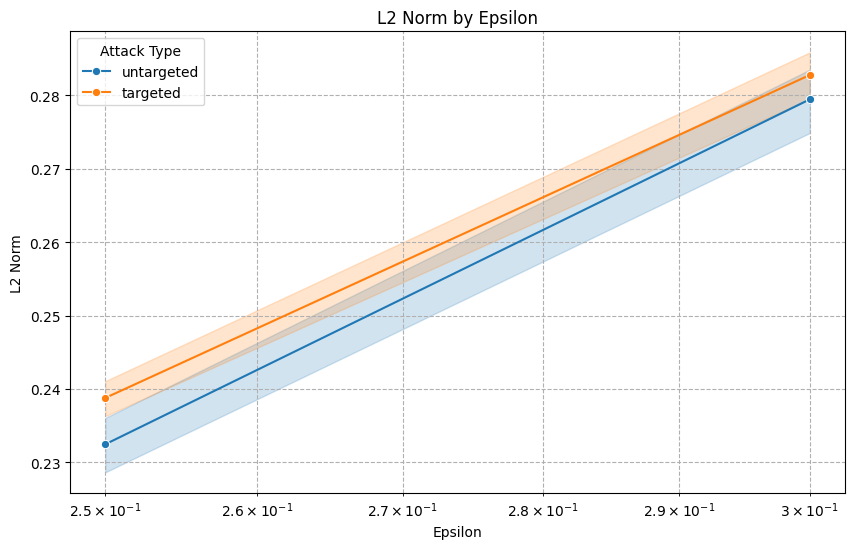

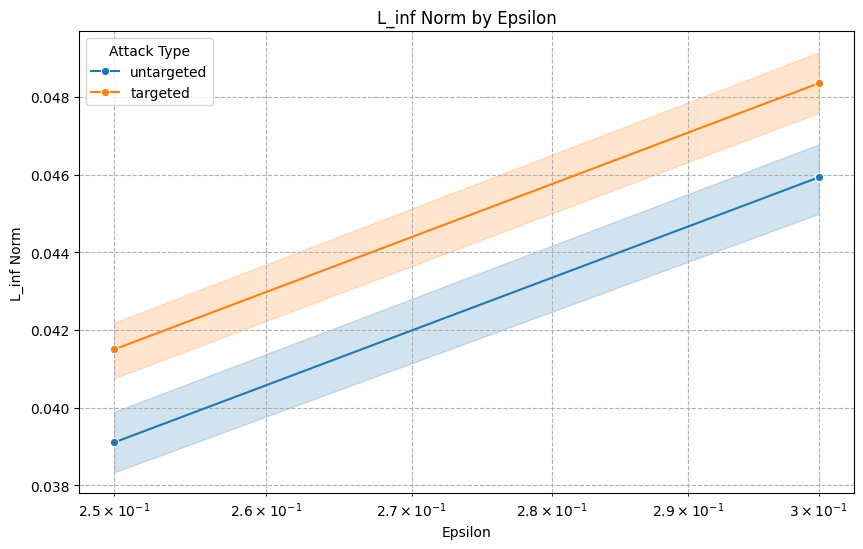

In [15]:
# Configuration for Attack Execution
EPSILONS = [0.25, 0.3]
MAX_ITERATIONS = 100
NUM_CLASSES = 10
TARGET_CLASS = 0

# Directories to save adversarial examples
ADV_DIR_UNTARGETED = 'adversarial_examples/untargeted_test_pgd2/'
ADV_DIR_TARGETED = 'adversarial_examples/targeted_test_pgd2/'
os.makedirs(ADV_DIR_UNTARGETED, exist_ok=True)
os.makedirs(ADV_DIR_TARGETED, exist_ok=True)

# Initialize results list
attack_results = []

# Attack Execution Loop
# Testing every 10th samples
for idx in tqdm(range(0, len(test_images), 10), desc="Performing Attacks"):
    image = test_images[idx].to(device)
    label = test_labels[idx].to(device)

    # Use the specified target class, but ensure it's different from the true label
    target_tensor = torch.tensor(TARGET_CLASS).to(device)
    if target_tensor == label:
        target_tensor = (target_tensor + 1) % NUM_CLASSES

    for epsilon in EPSILONS:
        step_size = epsilon / MAX_ITERATIONS
        # Untargeted Attack
        adv_image_ut, success_ut, iters_ut = iterative_gradient_attack(
            model=model,
            image=image,
            label=label,
            target=None,
            step_size=step_size,
            epsilon=epsilon,
            max_iters=MAX_ITERATIONS,
            device=device
        )

        ssim_score_ut, psnr_score_ut, l2_norm_ut, linf_norm_ut  = calculate_metrics(image, adv_image_ut, mean, std)

        if success_ut:
            adv_path_ut = os.path.join(ADV_DIR_UNTARGETED, f'adv_{idx}_eps_{epsilon}.pt')
            torch.save(adv_image_ut.cpu(), adv_path_ut)

        attack_results.append({
            'index': idx,
            'attack_type': 'untargeted',
            'epsilon': epsilon,
            'success': success_ut,
            'iterations': iters_ut,
            'l2_distance': l2_norm_ut,
            'ssim': ssim_score_ut,
            'psnr': psnr_score_ut,
            'linf_distance': linf_norm_ut
        })

        # Targeted Attack
        adv_image_tgt, success_tgt, iters_tgt = iterative_gradient_attack(
            model=model,
            image=image,
            label=label,
            target=target_tensor,
            step_size=step_size,
            epsilon=epsilon,
            max_iters=MAX_ITERATIONS,
            device=device
        )

        ssim_score_tgt, psnr_score_tgt, l2_norm_tgt, linf_norm_tgt  = calculate_metrics(image, adv_image_tgt, mean, std)

        if success_tgt:
            adv_path_tgt = os.path.join(ADV_DIR_TARGETED, f'adv_{idx}_eps_{epsilon}.pt')
            torch.save(adv_image_tgt.cpu(), adv_path_tgt)

        attack_results.append({
            'index': idx,
            'attack_type': 'targeted',
            'epsilon': epsilon,
            'success': success_tgt,
            'iterations': iters_tgt,
            'l2_distance': l2_norm_tgt,
            'ssim': ssim_score_tgt,
            'psnr': psnr_score_tgt,
            'linf_distance': linf_norm_tgt
        })

# Convert results to DataFrame
df_attack_results_pgd2 = pd.DataFrame(attack_results)
df_attack_results_pgd2.head()
df_attack_results_pgd2.to_csv(BASE_DIR+'/attack_results_pgd2.csv', index=False)

# Plot SSIM vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd2, x='epsilon', y='ssim', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('SSIM')
plt.title('SSIM by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot PSNR vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd2, x='epsilon', y='psnr', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('PSNR')
plt.title('PSNR by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot Success Rate vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd2, x='epsilon', y='success', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Success Rate')
plt.title('Success Rate by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot L2 Norm vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd2, x='epsilon', y='l2_distance', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('L2 Norm')
plt.title('L2 Norm by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot L_inf Norm vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd2, x='epsilon', y='linf_distance', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('L_inf Norm')
plt.title('L_inf Norm by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()


Performing Attacks: 100%|██████████| 1000/1000 [34:41<00:00,  2.08s/it]


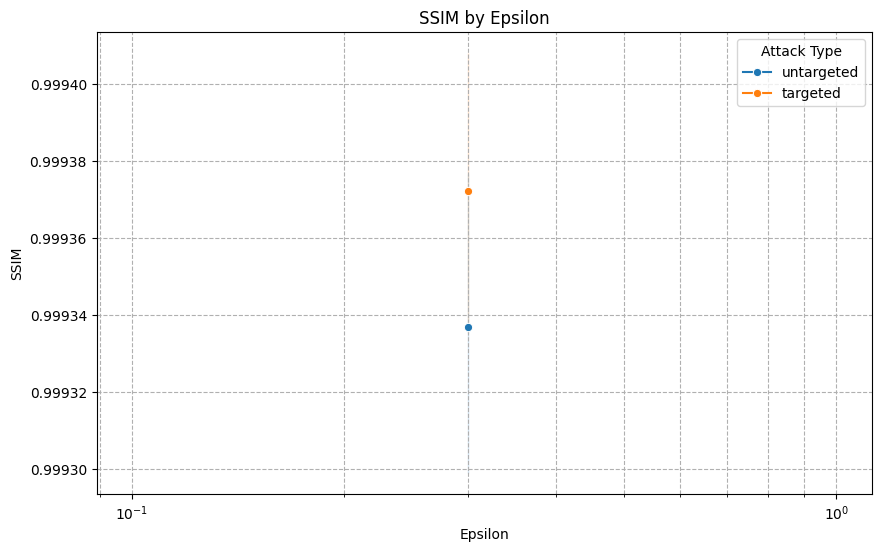

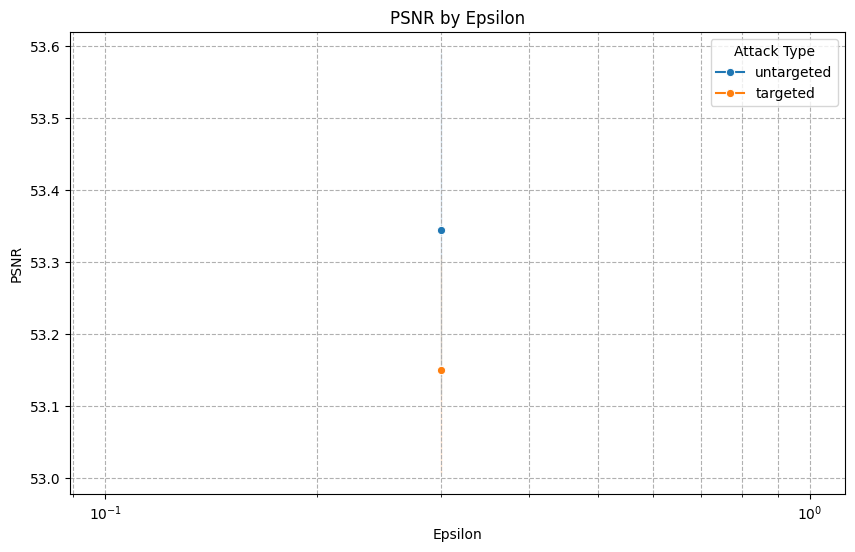

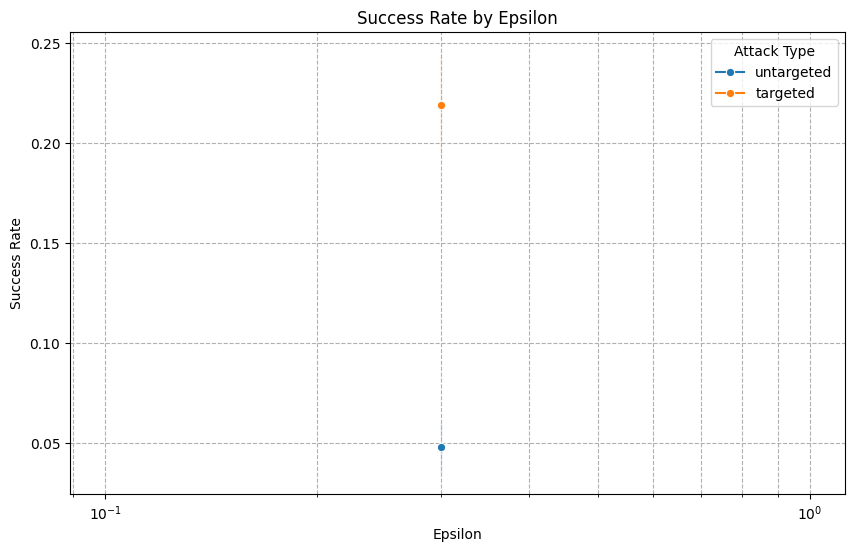

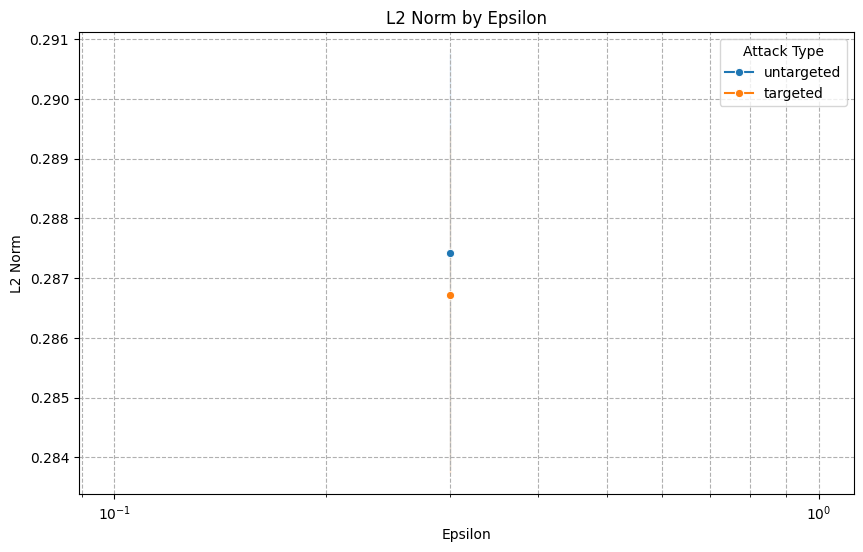

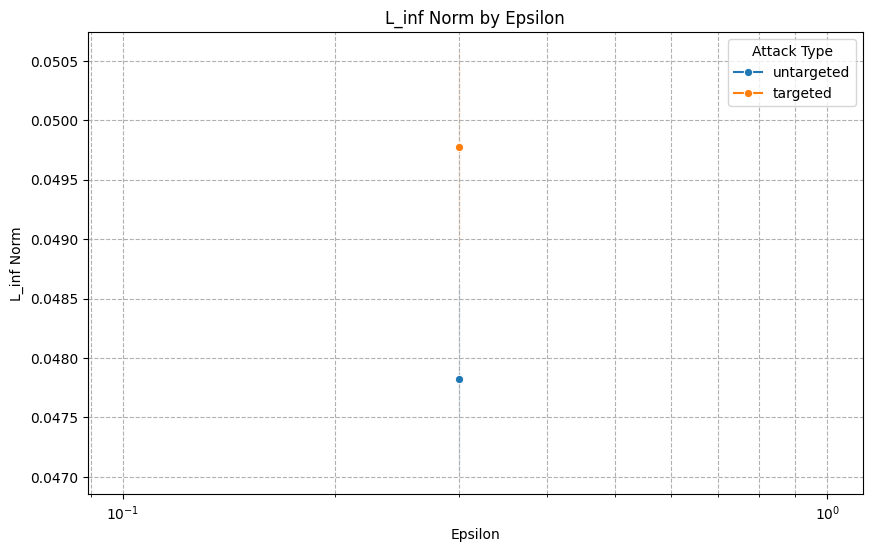

In [20]:
# Configuration for Attack Execution
EPSILONS = [0.3]
MAX_ITERATIONS = 100
STEP_SIZE_RATIO = 0.1
NUM_CLASSES = 10
TARGET_CLASS = 0

# Directories to save adversarial examples
ADV_DIR_UNTARGETED = 'adversarial_examples/untargeted_test_pgd3/'
ADV_DIR_TARGETED = 'adversarial_examples/targeted_test_pgd3/'
os.makedirs(ADV_DIR_UNTARGETED, exist_ok=True)
os.makedirs(ADV_DIR_TARGETED, exist_ok=True)

# Initialize results list
attack_results = []

# Attack Execution Loop
# Testing every 10th samples
for idx in tqdm(range(0, len(test_images), 10), desc="Performing Attacks"):
    image = test_images[idx].to(device)
    label = test_labels[idx].to(device)

    # Use the specified target class, but ensure it's different from the true label
    target_tensor = torch.tensor(TARGET_CLASS).to(device)
    if target_tensor == label:
        target_tensor = (target_tensor + 1) % NUM_CLASSES

    for epsilon in EPSILONS:
        step_size = epsilon * STEP_SIZE_RATIO
        # Untargeted Attack
        adv_image_ut, success_ut, iters_ut = iterative_gradient_attack(
            model=model,
            image=image,
            label=label,
            target=None,
            step_size=step_size,
            epsilon=epsilon,
            max_iters=MAX_ITERATIONS,
            device=device
        )

        ssim_score_ut, psnr_score_ut, l2_norm_ut, linf_norm_ut  = calculate_metrics(image, adv_image_ut, mean, std)

        if success_ut:
            adv_path_ut = os.path.join(ADV_DIR_UNTARGETED, f'adv_{idx}_eps_{epsilon}.pt')
            torch.save(adv_image_ut.cpu(), adv_path_ut)

        attack_results.append({
            'index': idx,
            'attack_type': 'untargeted',
            'epsilon': epsilon,
            'success': success_ut,
            'iterations': iters_ut,
            'l2_distance': l2_norm_ut,
            'ssim': ssim_score_ut,
            'psnr': psnr_score_ut,
            'linf_distance': linf_norm_ut
        })

        # Targeted Attack
        adv_image_tgt, success_tgt, iters_tgt = iterative_gradient_attack(
            model=model,
            image=image,
            label=label,
            target=target_tensor,
            step_size=step_size,
            epsilon=epsilon,
            max_iters=MAX_ITERATIONS,
            device=device
        )

        ssim_score_tgt, psnr_score_tgt, l2_norm_tgt, linf_norm_tgt  = calculate_metrics(image, adv_image_tgt, mean, std)

        if success_tgt:
            adv_path_tgt = os.path.join(ADV_DIR_TARGETED, f'adv_{idx}_eps_{epsilon}.pt')
            torch.save(adv_image_tgt.cpu(), adv_path_tgt)

        attack_results.append({
            'index': idx,
            'attack_type': 'targeted',
            'epsilon': epsilon,
            'success': success_tgt,
            'iterations': iters_tgt,
            'l2_distance': l2_norm_tgt,
            'ssim': ssim_score_tgt,
            'psnr': psnr_score_tgt,
            'linf_distance': linf_norm_tgt
        })

# Convert results to DataFrame
df_attack_results_pgd3 = pd.DataFrame(attack_results)
df_attack_results_pgd3.head()
df_attack_results_pgd3.to_csv(BASE_DIR+'/attack_results_pgd3.csv', index=False)

# Plot SSIM vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd2, x='epsilon', y='ssim', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('SSIM')
plt.title('SSIM by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot PSNR vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd2, x='epsilon', y='psnr', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('PSNR')
plt.title('PSNR by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot Success Rate vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd2, x='epsilon', y='success', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Success Rate')
plt.title('Success Rate by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot L2 Norm vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd2, x='epsilon', y='l2_distance', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('L2 Norm')
plt.title('L2 Norm by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot L_inf Norm vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_attack_results_pgd2, x='epsilon', y='linf_distance', hue='attack_type', marker='o')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('L_inf Norm')
plt.title('L_inf Norm by Epsilon')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()


In [17]:
# load saved csv to continue
df_attack_results_pgd = pd.read_csv(BASE_DIR+'/attack_results_pgd.csv')

df_attack_results_pgd2 = pd.read_csv(BASE_DIR+'/attack_results_pgd2.csv')

df_attack_results_pgd3 = pd.read_csv(BASE_DIR+'/attack_results_pgd3.csv')


#### Evaluation


In [ ]:

def load_adversarial_examples(adv_dir, attack_type):
    """
    Loads adversarial examples from a specified directory with attack type.

    Args:
        adv_dir (str): Path to the directory containing adversarial .pt files.
        attack_type (str): 'untargeted' or 'targeted'.

    Returns:
        list of tuples: Each tuple contains (image_tensor, index, step_size, attack_type).
    """
    adversarial_examples = []
    for filename in os.listdir(adv_dir):
        if filename.endswith('.pt'):
            path = os.path.join(adv_dir, filename)
            adv_image = torch.load(path)

            # Extract index and step_size from filename
            parts = filename.rstrip('.pt').split('_')
            idx = int(parts[1])
            step_size = float(parts[3])
            adversarial_examples.append((adv_image, idx, step_size, attack_type))
    return adversarial_examples

# Load all adversarial examples with attack type
adv_examples_untargeted = load_adversarial_examples(ADV_DIR_UNTARGETED, 'untargeted_test_pgd3')
adv_examples_targeted = load_adversarial_examples(ADV_DIR_TARGETED, 'targeted_test_pgd3')

# Combine all adversarial examples
all_adv_examples = adv_examples_untargeted + adv_examples_targeted
print(f"\nTotal Adversarial Examples Loaded for eps=0.3 and stepsize=0.03: {len(all_adv_examples)}")

<ipython-input-48-a451a2eaf5b4>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adv_image = torch.load(path)



Total Adversarial Examples Loaded: 3748


#### Data Aggregation

In [21]:
# Load the CSV files
df_pgd1 = pd.read_csv(BASE_DIR + '/attack_results_pgd.csv')
df_pgd2 = pd.read_csv(BASE_DIR + '/attack_results_pgd2.csv')

# Combine the DataFrames
df_combined = pd.concat([df_pgd1, df_pgd2], ignore_index=True)
df_combined.reset_index(drop=True, inplace=True)

print(df_combined.head())

   index attack_type  epsilon  success  iterations  l2_distance      ssim  \
0      0  untargeted     0.01    False         100         0.01  1.000000   
1      0    targeted     0.01    False         100         0.01  0.999999   
2      0  untargeted     0.05    False         100         0.05  0.999987   
3      0    targeted     0.05    False         100         0.05  0.999987   
4      0  untargeted     0.10    False         100         0.10  0.999949   

        psnr  linf_distance  
0  81.937156       0.001824  
1  81.936128       0.001630  
2  67.957755       0.008636  
3  67.956384       0.009164  
4  61.937198       0.016562  


In [22]:
# Check for missing values
print(df_combined.isnull().sum())

df_combined.dropna(inplace=True)
print(df_combined.dtypes)

index            0
attack_type      0
epsilon          0
success          0
iterations       0
l2_distance      0
ssim             0
psnr             0
linf_distance    0
dtype: int64
index              int64
attack_type       object
epsilon          float64
success             bool
iterations         int64
l2_distance      float64
ssim             float64
psnr             float64
linf_distance    float64
dtype: object


In [23]:
# Check unique epsilon values
print(df_combined['epsilon'].unique())

df_combined['epsilon'] = df_combined['epsilon'].astype(float)

[0.01 0.05 0.1  0.2  0.25 0.3 ]


In [26]:
# Threshold values
SUCCESS_RATE_THRESHOLD = 0.05
L2_NORM_THRESHOLD = 0.2
PSNR_THRESHOLD = 60
SSIM_THRESHOLD = 0.99

# Group by relevant parameters
grouped = df_combined.groupby(['epsilon', 'attack_type'])

# Calculate success rate and other metrics
metrics = grouped.agg(
    total_attacks=('success', 'count'),
    successful_attacks=('success', 'sum'),
    average_l2_norm=('l2_distance', 'mean'),
    average_psnr=('psnr', 'mean'),
    average_ssim=('ssim', 'mean')
).reset_index()

# Calculate success rate
metrics['success_rate'] = metrics['successful_attacks'] / metrics['total_attacks']


gold_standard = metrics[
    (metrics['success_rate'] >= SUCCESS_RATE_THRESHOLD) &
    (metrics['average_l2_norm'] <= L2_NORM_THRESHOLD) &
    (metrics['average_psnr'] >= PSNR_THRESHOLD) &
    (metrics['average_ssim'] >= SSIM_THRESHOLD)
]

print(gold_standard)

   epsilon attack_type  total_attacks  successful_attacks  average_l2_norm  \
1     0.01  untargeted           1000                  79         0.009289   
3     0.05  untargeted           1000                  78         0.046490   
5     0.10  untargeted           1000                  78         0.092980   

   average_psnr  average_ssim  success_rate  
1     83.616937      0.999999         0.079  
3     69.626862      0.999982         0.078  
5     63.612888      0.999927         0.078  


In [27]:
# Apply criteria to individual samples
gold_standard_samples = df_combined[
    (df_combined['success'] == True) &
    (df_combined['l2_distance'] <= L2_NORM_THRESHOLD) &
    (df_combined['psnr'] >= PSNR_THRESHOLD) &
    (df_combined['ssim'] >= SSIM_THRESHOLD)
]

print(gold_standard_samples)

       index attack_type  epsilon  success  iterations  l2_distance      ssim  \
61        70    targeted     0.10     True          15     0.077888  0.999882   
63        70    targeted     0.20     True          10     0.083163  0.999863   
376      470  untargeted     0.01     True           1     0.001008  1.000000   
378      470  untargeted     0.05     True           1     0.005033  1.000000   
380      470  untargeted     0.10     True           1     0.009977  1.000000   
...      ...         ...      ...      ...         ...          ...       ...   
11938   9840  untargeted     0.30     True           1     0.030031  0.999991   
11984   9960  untargeted     0.25     True           1     0.024944  0.999995   
11985   9960    targeted     0.25     True           1     0.025117  0.999995   
11986   9960  untargeted     0.30     True           1     0.029915  0.999991   
11987   9960    targeted     0.30     True           1     0.030203  0.999990   

             psnr  linf_dis

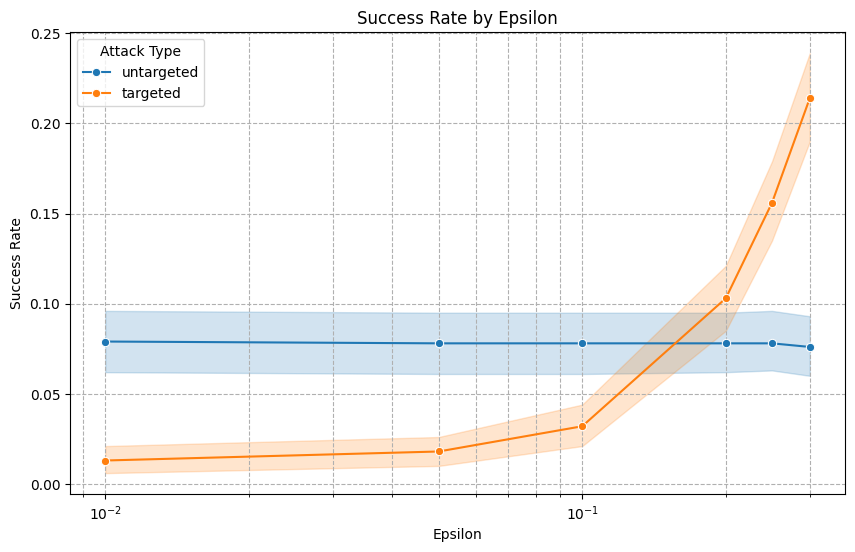

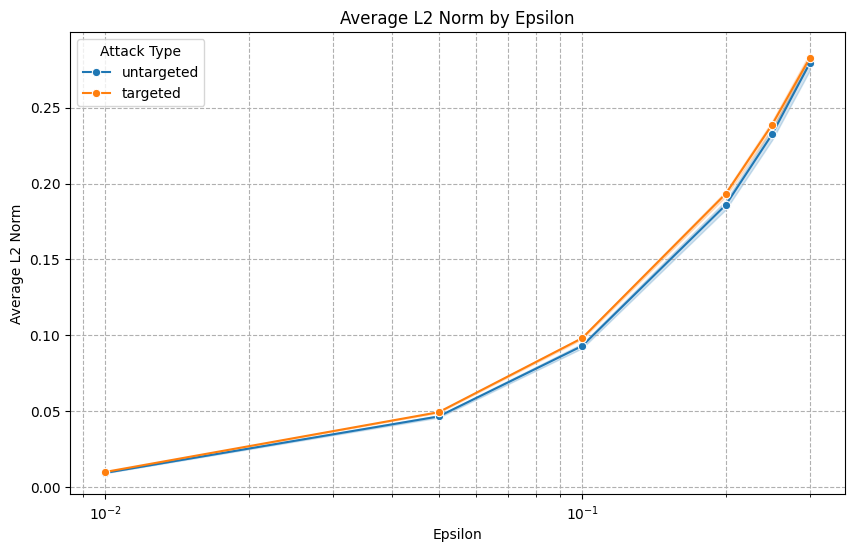

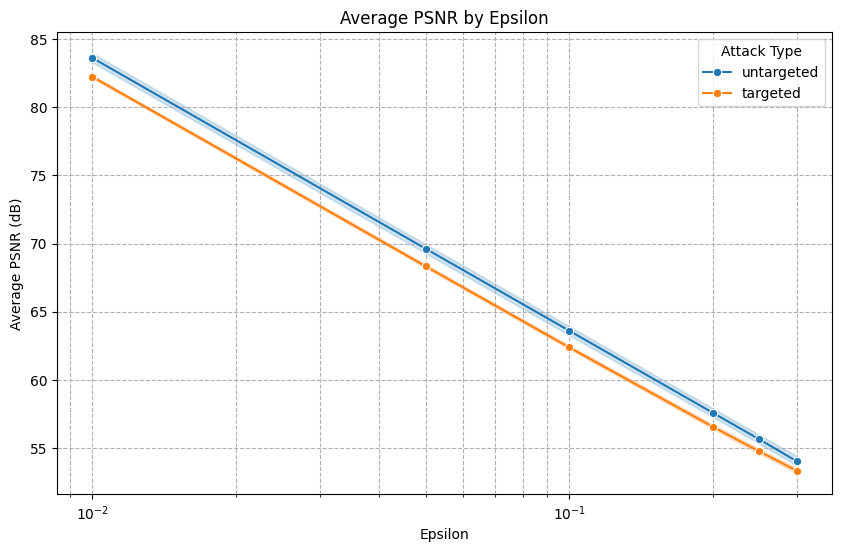

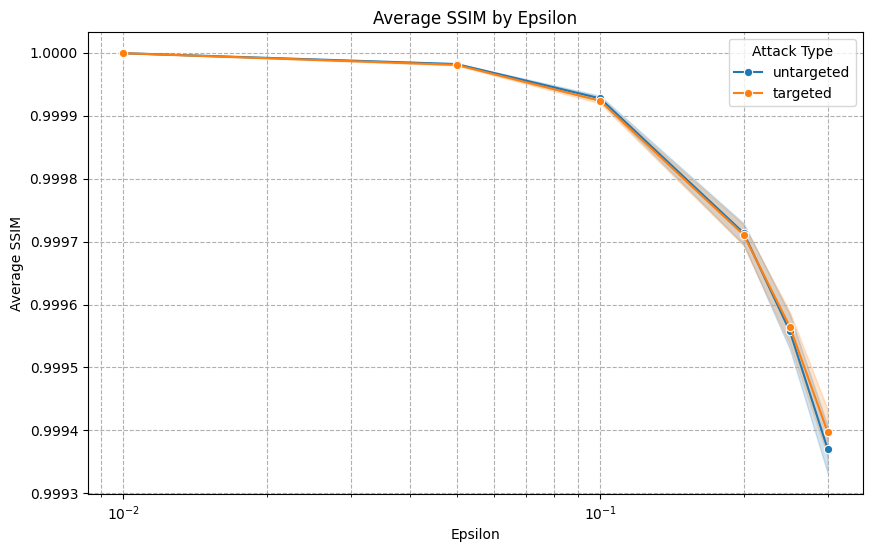

In [38]:
# Combine 1st sweep (0.01,0.05,0.1,0.2) and 2nd sweep (0.25,0.3) across epsilons


# Plot Success Rate vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_combined, x='epsilon', y='success', hue='attack_type', marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Success Rate')
plt.title('Success Rate by Epsilon')
plt.xscale('log')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot L2 Norm vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_combined, x='epsilon', y='l2_distance', hue='attack_type', marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Average L2 Norm')
plt.title('Average L2 Norm by Epsilon')
plt.xscale('log')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot PSNR vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_combined, x='epsilon', y='psnr', hue='attack_type', marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Average PSNR (dB)')
plt.title('Average PSNR by Epsilon')
plt.xscale('log')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot SSIM vs Epsilon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_combined, x='epsilon', y='ssim', hue='attack_type', marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Average SSIM')
plt.title('Average SSIM by Epsilon')
plt.xscale('log')
plt.legend(title='Attack Type')
plt.grid(True, which="both", ls="--")
plt.show()

# Defense Strategy

In [43]:
def compress_image(tensor_image, compression_level=50):
    """
    Compresses a tensor image using JPEG compression tailored to custom normalization.

    Args:
        tensor_image (torch.Tensor): The input image tensor of shape (C, H, W).
        compression_level (int): JPEG compression quality (1-100).

    Returns:
        torch.Tensor: The compressed and decompressed image tensor.
    """
    # Normalization parameters
    MEAN = torch.tensor([0.0127]).view(1,1,1)
    STD = torch.tensor([0.8197]).view(1,1,1)

    # Unnormalize the image
    image = tensor_image.clone().detach().cpu()
    image = image * STD + MEAN  # (C, H, W)

    # Clamp the image to [0, 1]
    image = torch.clamp(image, 0, 1)

    # Convert to PIL Image
    if image.shape[0] == 1:
        # Grayscale image
        image_pil = transforms.ToPILImage()(image.squeeze(0))
    else:
        # RGB
        image_pil = transforms.ToPILImage()(image)

    # Compress and decompress using JPEG
    buffer = io.BytesIO()
    image_pil.save(buffer, format='JPEG', quality=compression_level)
    buffer.seek(0)
    compressed_image_pil = Image.open(buffer)

    # Convert back to tensor
    compressed_image = transforms.ToTensor()(compressed_image_pil)

    # Re-normalize the image
    compressed_image = (compressed_image - MEAN) / STD

    # Ensure the tensor is on the original device and has gradient tracking disabled
    return compressed_image.to(tensor_image.device)

def feature_squeeze(tensor_image, bit_depth=4):
    """
    Applies feature squeezing by reducing color depth.

    Args:
        tensor_image (torch.Tensor): The input image tensor of shape (C, H, W).
        bit_depth (int): Number of bits to keep per channel.

    Returns:
        torch.Tensor: The feature-squeezed image tensor.
    """
    squeezed_image = torch.floor(tensor_image * (2 ** bit_depth)) / (2 ** bit_depth)
    return squeezed_image

def apply_defense(image, compression_level=50, bit_depth=4):
    """
    Applies defense mechanisms to the input image.

    Args:
        image (torch.Tensor): The input image tensor.
        compression_level (int): JPEG compression quality.
        bit_depth (int): Number of bits to keep per channel for feature squeezing.

    Returns:
        torch.Tensor: The defended image tensor.
    """
    # Apply Image Compression
    defended_image = compress_image(image, compression_level=compression_level)

    # Apply Feature Squeezing
    defended_image = feature_squeeze(defended_image, bit_depth=bit_depth)

    return defended_image

In [45]:
# Configuration for Defense
# range of 1-100
COMPRESSION_LEVEL = 50
# number of bits
BIT_DEPTH = 4
STEP_SIZE_RATIO = 0.1
EPSILONS = [0.3]
MAX_ITERATIONS = 100

# Directories to save adversarial examples
ADV_DIR_UNTARGETED = 'adversarial_examples/untargeted_def/'
ADV_DIR_TARGETED = 'adversarial_examples/targeted_def/'
os.makedirs(ADV_DIR_UNTARGETED, exist_ok=True)
os.makedirs(ADV_DIR_TARGETED, exist_ok=True)

# Initialize results list
attack_results = []

# Attack Execution Loop Without Defense
for idx in tqdm(range(0, len(test_images), 10), desc="Performing Attacks"):
    image = test_images[idx].to(device)
    label = test_labels[idx].to(device)

    # Define target class
    target_tensor = torch.tensor(TARGET_CLASS).to(device)
    if target_tensor == label:
        target_tensor = (target_tensor + 1) % NUM_CLASSES

    for epsilon in EPSILONS:
        step_size = epsilon * STEP_SIZE_RATIO

        # Untargeted Attack without Defense
        adv_image_ut, success_ut, iters_ut = iterative_gradient_attack(
            model=model,
            image=image,
            label=label,
            target=None,
            step_size=step_size,
            epsilon=epsilon,
            max_iters=MAX_ITERATIONS,
            device=device,
            momentum_alpha=0.9,
        )

        # Apply defense after attack
        defended_adv_image_ut = apply_defense(adv_image_ut, compression_level=COMPRESSION_LEVEL, bit_depth=BIT_DEPTH)
        ssim_score_ut, psnr_score_ut, l2_norm_ut, linf_norm_ut = calculate_metrics(image, defended_adv_image_ut, mean, std)

        if success_ut:
            adv_path_ut = os.path.join(ADV_DIR_UNTARGETED, f'adv_defended_{idx}_eps_{epsilon}.pt')
            torch.save(defended_adv_image_ut.cpu(), adv_path_ut)

        attack_results.append({
            'index': idx,
            'attack_type': 'untargeted_defended',
            'epsilon': epsilon,
            'success': success_ut,
            'iterations': iters_ut,
            'l2_distance': l2_norm_ut,
            'ssim': ssim_score_ut,
            'psnr': psnr_score_ut,
            'linf_distance': linf_norm_ut
        })

        # Targeted Attack without Defense
        adv_image_tgt, success_tgt, iters_tgt = iterative_gradient_attack(
            model=model,
            image=image,
            label=label,
            target=target_tensor,
            step_size=step_size,
            epsilon=epsilon,
            max_iters=MAX_ITERATIONS,
            device=device,
            momentum_alpha=0.9,
        )

        # Apply defense after attack
        defended_adv_image_tgt = apply_defense(adv_image_tgt, compression_level=COMPRESSION_LEVEL, bit_depth=BIT_DEPTH)
        ssim_score_tgt, psnr_score_tgt, l2_norm_tgt, linf_norm_tgt = calculate_metrics(image, defended_adv_image_tgt, mean, std)

        if success_tgt:
            adv_path_tgt = os.path.join(ADV_DIR_TARGETED, f'adv_defended_{idx}_eps_{epsilon}.pt')
            torch.save(defended_adv_image_tgt.cpu(), adv_path_tgt)

        attack_results.append({
            'index': idx,
            'attack_type': 'targeted_defended',
            'epsilon': epsilon,
            'success': success_tgt,
            'iterations': iters_tgt,
            'l2_distance': l2_norm_tgt,
            'ssim': ssim_score_tgt,
            'psnr': psnr_score_tgt,
            'linf_distance': linf_norm_tgt
        })

# Convert results to DataFrame
df_attack_results_def = pd.DataFrame(attack_results)
df_attack_results_def.head()
df_attack_results_def.to_csv(BASE_DIR+'/attack_results_def.csv', index=False)

Performing Attacks: 100%|██████████| 1000/1000 [36:26<00:00,  2.19s/it]


In [53]:
import pandas as pd

# Load your DataFrames
df_attack_results_pgd3 = pd.read_csv(os.path.join(BASE_DIR, 'attack_results_pgd3.csv'))
df_attack_results_def = pd.read_csv(os.path.join(BASE_DIR, 'attack_results_def.csv'))

# Assign defense status
df_undefended = df_attack_results_pgd3.copy()
df_undefended['defense'] = 'Undefended'

df_defended = df_attack_results_def.copy()
df_defended['defense'] = 'Defended'

# Combine both DataFrames
df_combined = pd.concat([df_undefended, df_defended], ignore_index=True)

# Since epsilon is constant, you can drop it or keep it for reference
# For clarity, we'll drop it in this visualization
df_combined = df_combined.drop(columns=['epsilon'])

In [54]:
# Calculate Accuracy as 1 - Success Rate
df_combined['accuracy'] = 1 - df_combined['success']

# Group by defense and attack_type to calculate mean metrics
aggregated_metrics = df_combined.groupby(['defense', 'attack_type']).agg(
    average_accuracy=('accuracy', 'mean'),
    average_psnr=('psnr', 'mean'),
    average_ssim=('ssim', 'mean'),
    average_l2_norm=('l2_distance', 'mean'),
    average_iterations=('iterations', 'mean')
).reset_index()

print(aggregated_metrics)

      defense          attack_type  average_accuracy  average_psnr  \
0    Defended    targeted_defended             0.780     16.407704   
1    Defended  untargeted_defended             0.952     16.407351   
2  Undefended             targeted             0.781     53.150380   
3  Undefended           untargeted             0.952     53.344170   

   average_ssim  average_l2_norm  average_iterations  
0      0.594228        20.971878              79.753  
1      0.594182        20.972301              95.248  
2      0.999372         0.286713              79.717  
3      0.999337         0.287418              95.248  


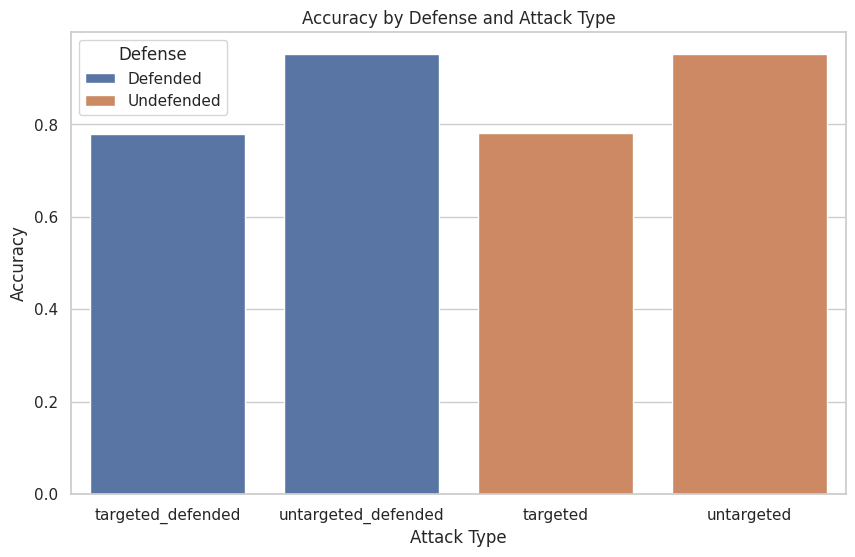

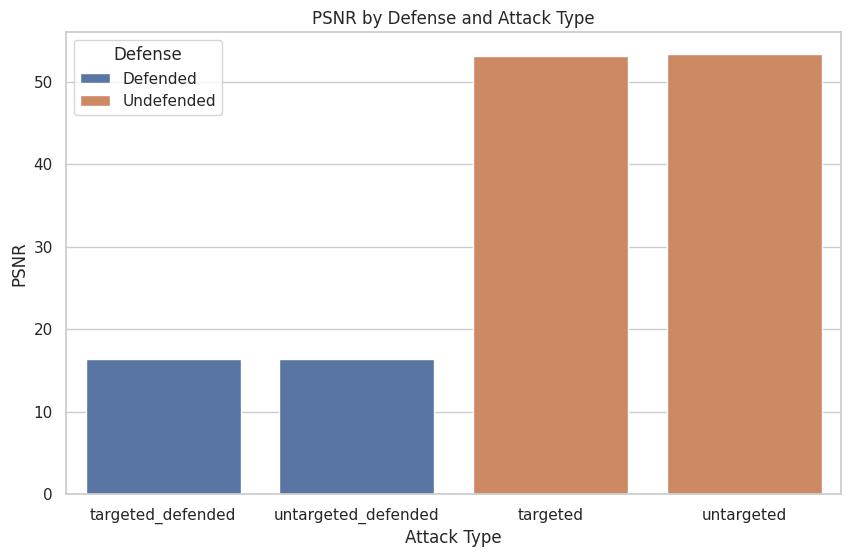

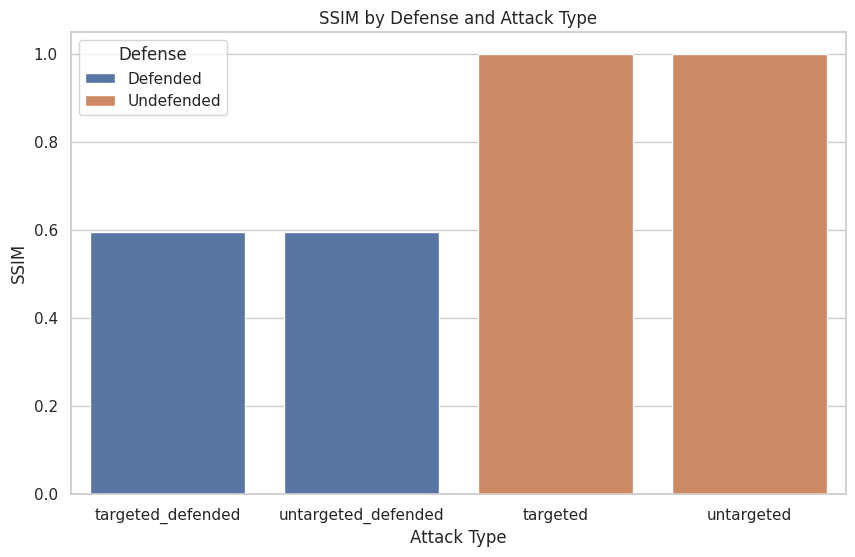

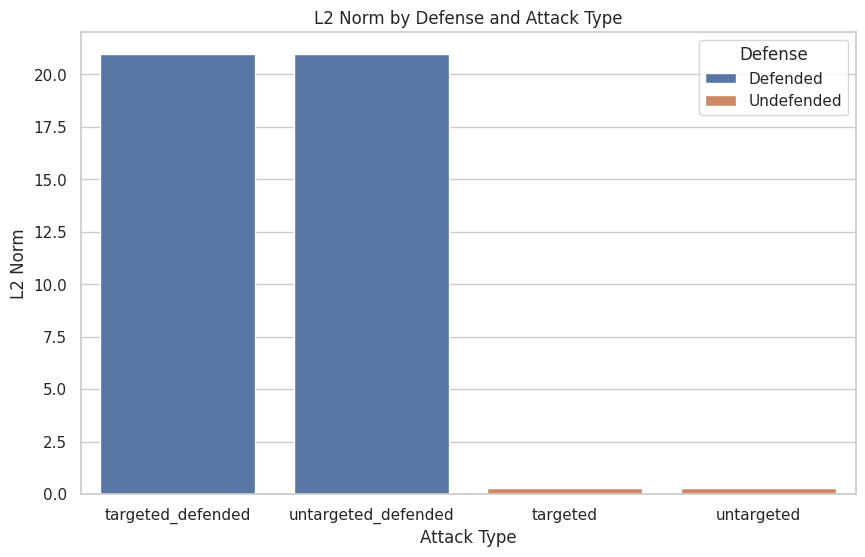

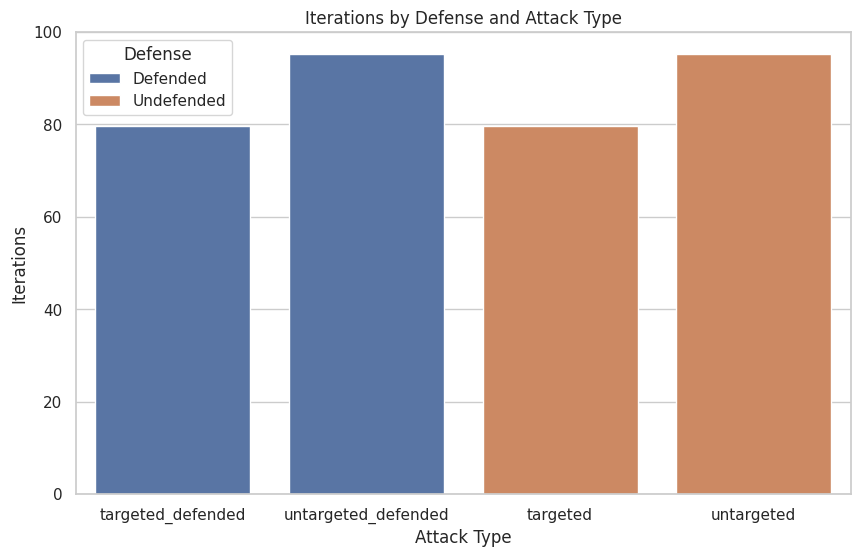

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# List of metrics to plot
metrics_to_plot = ['average_accuracy', 'average_psnr', 'average_ssim', 'average_l2_norm', 'average_iterations']

# Define metric labels for better readability
metric_labels = {
    'average_accuracy': 'Accuracy',
    'average_psnr': 'PSNR',
    'average_ssim': 'SSIM',
    'average_l2_norm': 'L2 Norm',
    'average_iterations': 'Iterations'
}

# Plot each metric
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=aggregated_metrics, x='attack_type', y=metric, hue='defense')
    plt.title(f'{metric_labels[metric]} by Defense and Attack Type')
    plt.xlabel('Attack Type')
    plt.ylabel(metric_labels[metric])
    plt.legend(title='Defense')
    plt.show()

In [58]:
df_attack_results_pgd3 = pd.read_csv(os.path.join(BASE_DIR, 'attack_results_pgd3.csv'))
df_attack_results_def = pd.read_csv(os.path.join(BASE_DIR, 'attack_results_def.csv'))

# Display the columns of each DataFrame
print("Columns in df_attack_results_pgd3:")
print(df_attack_results_pgd3.columns.tolist())

print("\nColumns in df_attack_results_def:")
print(df_attack_results_def.columns.tolist())

Columns in df_attack_results_pgd3:
['index', 'attack_type', 'epsilon', 'success', 'iterations', 'l2_distance', 'ssim', 'psnr', 'linf_distance']

Columns in df_attack_results_def:
['index', 'attack_type', 'epsilon', 'success', 'iterations', 'l2_distance', 'ssim', 'psnr', 'linf_distance']


Processing Adversarial Image: adv_0_eps_0.1.pt (Idx: 0, ε: 0.1)
Processing Adversarial Image: adv_40_eps_0.01.pt (Idx: 40, ε: 0.01)


<ipython-input-83-0af282cc0bb8>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adv_image = torch.load(adv_path).to('cpu')


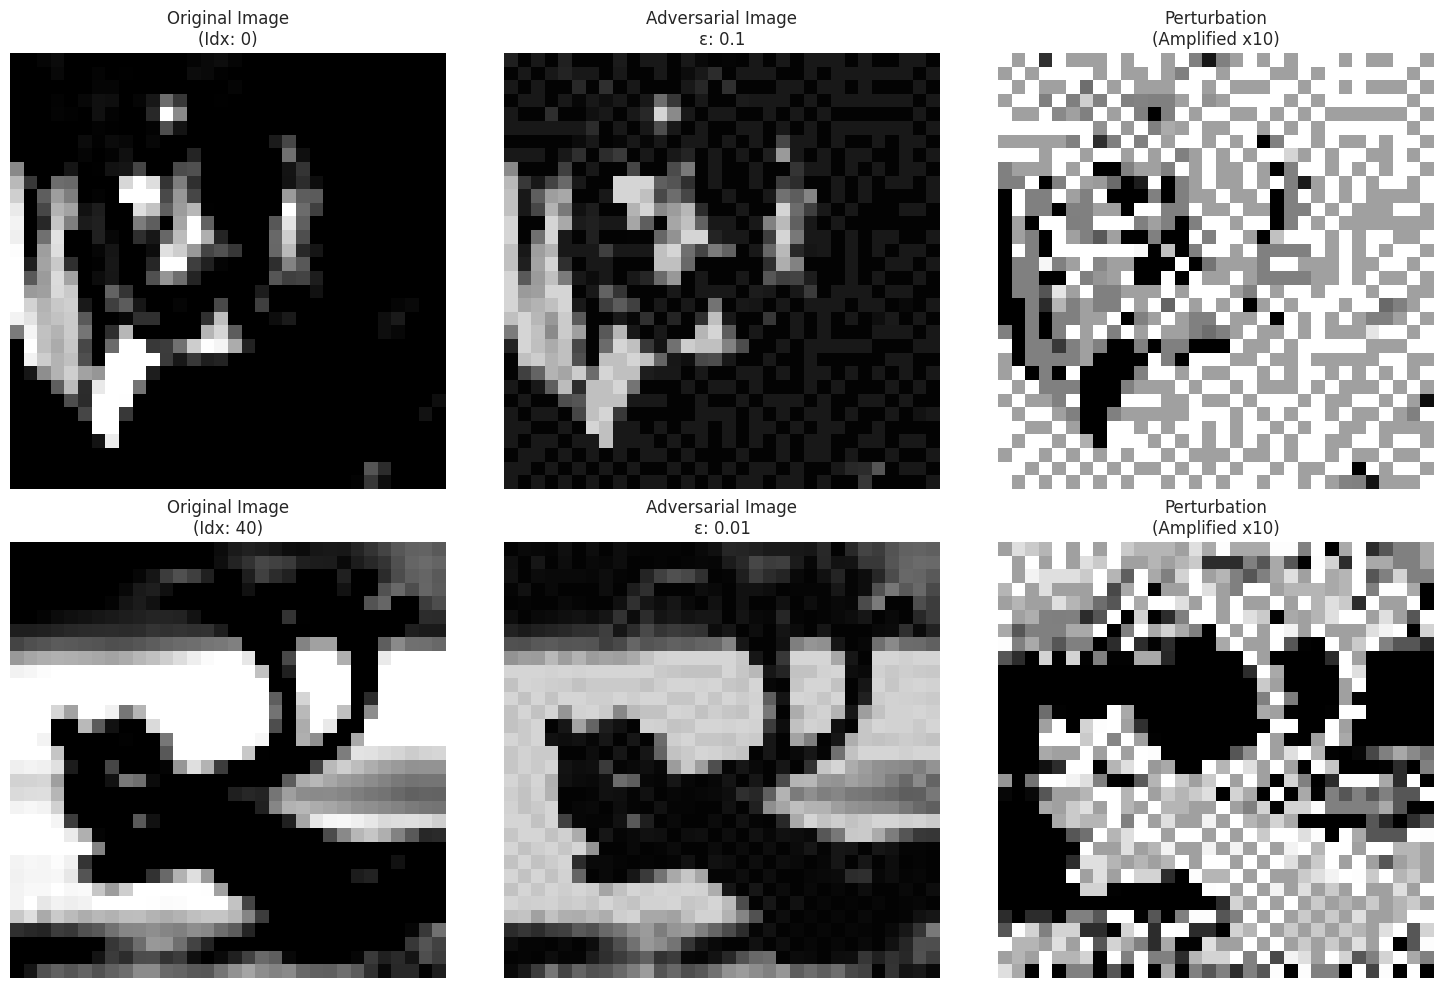

In [83]:
import re

# Configuration Parameters
ADV_DIR_UNTARGETED = os.path.join(BASE_DIR, 'adversarial_examples', 'untargeted')
ADV_DIR_TARGETED = os.path.join(BASE_DIR, 'adversarial_examples', 'targeted')

# Normalization Parameters
MEAN = 0.0127
STD = 0.8197

# Unnormalize Function for Grayscale Images with Shape (1, H, W)
def unnormalize_grayscale(tensor, mean, std):
    """
    Unnormalizes a tensor image for grayscale images with shape (C, H, W).

    Args:
        tensor (torch.Tensor): Normalized image tensor of shape (1, H, W).
        mean (float): Mean used for normalization.
        std (float): Standard deviation used for normalization.

    Returns:
        torch.Tensor: Unnormalized image tensor of shape (H, W).
    """
    tensor = tensor.clone().detach()
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    tensor = tensor.squeeze(0)
    return tensor

# Convert Tensor to NumPy for Plotting (Grayscale)
def tensor_to_numpy_grayscale(tensor):
    """
    Converts a torch tensor to a NumPy array for plotting (Grayscale).

    Args:
        tensor (torch.Tensor): Image tensor of shape (H, W).

    Returns:
        np.ndarray: Image array of shape (H, W).
    """
    tensor = tensor.cpu().numpy()
    return tensor

'''
Filename adv_0_eps_1e-05.pt does not match the expected format. Skipping.
Filename adv_0_eps_0.0001.pt does not match the expected format. Skipping.
Filename adv_0_eps_0.001.pt does not match the expected format. Skipping.
Filename adv_0_eps_0.01.pt does not match the expected format. Skipping.
Filename adv_0_eps_0.1.pt does not match the expected format. Skipping.
'''
# Function to get all adversarial image paths
# List of Adversarial Image Paths
adv_image_paths = [
    '/content/drive/MyDrive/COMP90073/Assignment2/A2-data/adversarial_examples/targeted/adv_0_eps_0.1.pt',
    #'/content/drive/MyDrive/COMP90073/Assignment2/A2-data/adversarial_examples/untargeted/adv_50_eps_1e-5.pt',
    '/content/drive/MyDrive/COMP90073/Assignment2/A2-data/adversarial_examples/targeted/adv_40_eps_0.01.pt',

]

# Number of samples to plot
num_samples = len(adv_image_paths)

# Initialize the Plot
plt.figure(figsize=(15, num_samples * 5))

# Iterate Over the Specified Adversarial Image Paths and Plot
for i, adv_path in enumerate(adv_image_paths):
    # Extract filename from the path
    filename = os.path.basename(adv_path)

    # Define the regex pattern based on your filename structure
    # Example filename: 'adv_0_eps_0.3.pt'
    pattern = r'adv_(\d+)_eps_([0-9.e-]+)\.pt'
    match = re.match(pattern, filename)

    if not match:
        print(f"Filename '{filename}' does not match the expected format 'adv_<idx>_eps_<epsilon>.pt'. Skipping.")
        continue

    idx = int(match.group(1))
    epsilon = float(match.group(2))

    print(f"Processing Adversarial Image: {filename} (Idx: {idx}, ε: {epsilon})")

    # Check if the adversarial image file exists
    if not os.path.exists(adv_path):
        print(f"Adversarial image file not found: {adv_path}. Skipping.")
        continue

    # Load the Adversarial Image
    adv_image = torch.load(adv_path).to('cpu')

    try:
        original_image = test_images[idx].to('cpu')
    except IndexError:
        print(f"Original image with index {idx} not found in 'test_images'. Skipping.")
        continue
    except Exception as e:
        print(f"Error loading original image at index {idx}: {e}. Skipping.")
        continue

    # Unnormalize the Images
    original_image_unnorm = unnormalize_grayscale(original_image, MEAN, STD)
    adv_image_unnorm = unnormalize_grayscale(adv_image, MEAN, STD)

    # Convert to NumPy
    original_np = tensor_to_numpy_grayscale(original_image_unnorm)
    adv_np = tensor_to_numpy_grayscale(adv_image_unnorm)

    # Compute Perturbation (Adv - Original)
    perturbation = adv_image_unnorm - original_image_unnorm

    # Convert perturbation to NumPy
    perturbation_np = tensor_to_numpy_grayscale(perturbation)

    # Amplify the perturbation for visualization
    amplification_factor = 10
    perturbation_np_amplified = perturbation_np * amplification_factor + 0.5
    perturbation_np_amplified = np.clip(perturbation_np_amplified, 0, 1)

    # Plotting Original Image
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(original_np, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Original Image\n(Idx: {idx})')
    plt.axis('off')

    # Plotting Adversarial Image
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(adv_np, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Adversarial Image\nε: {epsilon}')
    plt.axis('off')

    # Plotting Perturbation
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(perturbation_np_amplified, cmap='gray', vmin=0, vmax=1)
    plt.title('Perturbation\n(Amplified x10)')
    plt.axis('off')

plt.tight_layout()
plt.show()